# Fake News detection with tensorflow and nltk using LSTMs

## Download dataset from kaggle

In [1]:
# Install kaggle library
!pip install -q kaggle

In [ ]:
# Import kaggle API token
from google.colab import files
files.upload()

In [3]:
# Activate kaggle token
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download dataset as zip
!kaggle datasets download mohammadaflahkhan/fake-news-dataset-combined-different-sources

 96% 77.0M/80.3M [00:00<00:00, 108MB/s]
100% 80.3M/80.3M [00:00<00:00, 103MB/s]


In [5]:
!mkdir data
!unzip fake-news-dataset-combined-different-sources.zip -d data
!mv ./data/PreProcessedData.csv ./data/RawKaggleData.csv

Archive:  fake-news-dataset-combined-different-sources.zip
  inflating: data/PreProcessedData.csv  


## Data exploration and preprocessing

In [6]:
# Import all necessary libraries for preprocessing
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt 

import seaborn as sns
plt.style.use("ggplot")

In [7]:
# Load dataset
df = pd.read_csv("./data/RawKaggleData.csv")

In [8]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'Ground Label'], dtype='object')

In [9]:
len(df)

69045

In [10]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [11]:
df["title"][0]

' Ann Coulter Make Believes She Has ‘Gay Friends’ To Make A Racist Point (TWEET)'

In [12]:
df["title"].describe()

count                                                 68365
unique                                                56948
top       Factbox: Trump fills top jobs for his administ...
freq                                                     14
Name: title, dtype: object

In [13]:
df["text"].describe()

count     68978
unique    57716
top            
freq        769
Name: text, dtype: object

As we can see there are duplicates in our dataset. But we will check that later with combined title and text.

In [14]:
# Drop unnamed colmns, change the columns names, combine title with text, change the way that fake/real news are labeled
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.rename(columns={"Ground Label": "real"})
df["text"] = df["title"] + ". " + df["text"]
df = df.drop(columns=["title"])
df["real"] = df["real"].eq("true").mul(1)
df.head()

,text,real
0,Ann Coulter Make Believes She Has ‘Gay Friend...,0
1,Rating: Moody‘s verbessert Ausblick für Russla...,0
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,0
3,Republicans on Obamacare repeal: 'We're going ...,1
4,"Trump, on possible DACA deal, says border wall...",1


In [15]:
df["text"].describe()

count                                                 68298
unique                                                58739
top       Highlights: The Trump presidency on April 13 a...
freq                                                      8
Name: text, dtype: object

In [16]:
# Remove duplicates
df = df.drop_duplicates("text")

In [17]:
all_length = len(df)

In [18]:
def display_distribution(df):
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]), color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]), color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('# of News Articles', size=15)

  
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]) / all_length, color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]) / all_length, color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('Proportion of News Articles', size=15)

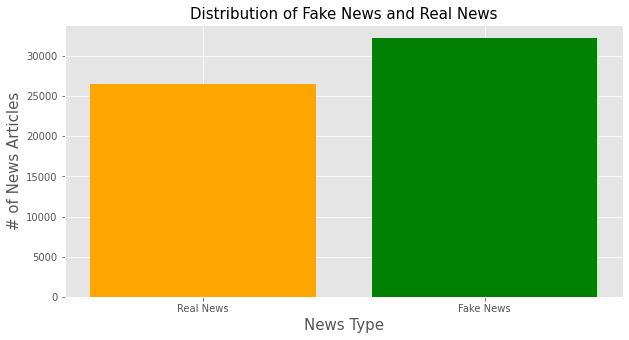

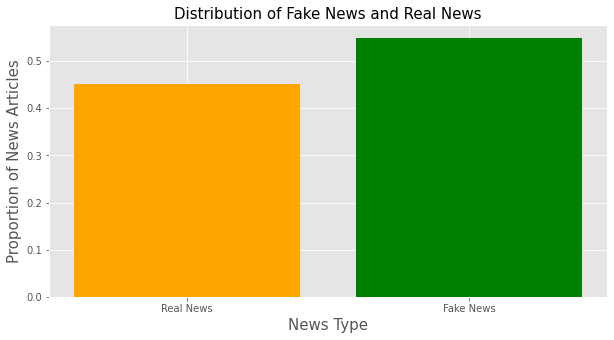

In [19]:
# Plot Fake News / Real News
display_distribution(df)

In [20]:
pp_diff = (len(df[df['real']==0]) - len(df[df['real']==1])) * 100 / all_length
print(f"Percent point different: {pp_diff}")

Percent point different: 9.805924412665986


As we can see the difference in occurences of fake news to real news is significant. We need to fix that.

In [21]:
df_real = df[df["real"]==1]
df_fake = df[df["real"]==0]
n = len(df_real) # Since there is less real news
df_fake = df_fake.sample(n=n, random_state=42)
df_bal = pd.concat([df_real, df_fake], ignore_index=True) # balanced dataframe

In [22]:
df_bal.head()

,text,real
0,Republicans on Obamacare repeal: 'We're going ...,1
1,"Trump, on possible DACA deal, says border wall...",1
2,Trump health pick favors insurance for people ...,1
3,Clarivate Analytics Roadshow 2017. This year’s...,1
4,Trump travel restrictions hit demand for visit...,1


Now lets look at the distribution one more time

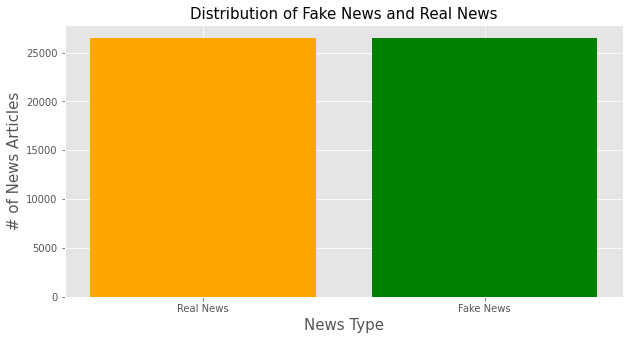

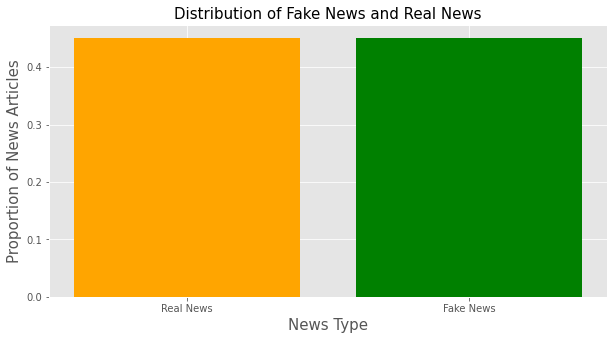

In [23]:
# Plot Fake News / Real News
display_distribution(df_bal)

## Split data for training+validation and testing

In [24]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_bal, test_size=0.30, random_state=27)

Now we can save the training and testting dataset separatly.

In [25]:
df_train.to_csv("fake-news-train.csv")
df_test.to_csv("fake-news-test.csv")

I have downloaded them to my github repo where they can be accessed

## Loading train dataset only

Datasets can be found at the repo: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection